In [25]:
import rampy as rp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from datetime import datetime
import os

from pydantic import BaseModel
from typing import List

import matplotlib.dates as mdates
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from scipy.signal import savgol_filter

In [26]:
class XRange(BaseModel):
    lower_limit:float
    higher_limit:float

def _select_range(x_range:XRange, data:np.array) -> np.array:
    cond1 = data[:,0] > x_range.lower_limit
    cond2 = data[:,0] < x_range.higher_limit
    cond = cond1 & cond2
    data = data[cond].copy()
    return data

def load_data(filename:str, x_range:XRange=None,  basepath:str="./data") -> np.array:
    # from glob import glob
    import os
    filepath = os.path.join(basepath, f"{filename}")
    if(os.path.exists(filepath) == False):
        raise FileExistsError(f"{filepath=} is not exists")
    spectrum = np.genfromtxt(filepath)
    # Flip X-axis
    spectrum = rp.flipsp(spectrum)
    if(x_range != None):
        assert isinstance(x_range, XRange), f"limit_x must be `XRange`"
        spectrum = _select_range(x_range=x_range, data=spectrum)
    return spectrum

In [27]:
names = []
spectrums = []
x_range = XRange(lower_limit=900, higher_limit=1600)
for fname in glob("./data/*"):
    spectrum = load_data(filename=fname, x_range=x_range, basepath='')
    target = os.path.split(fname)[1].split('_')[0]
    names.append(target)
    spectrums.append(spectrum)


thenar
thenar
200
index
index


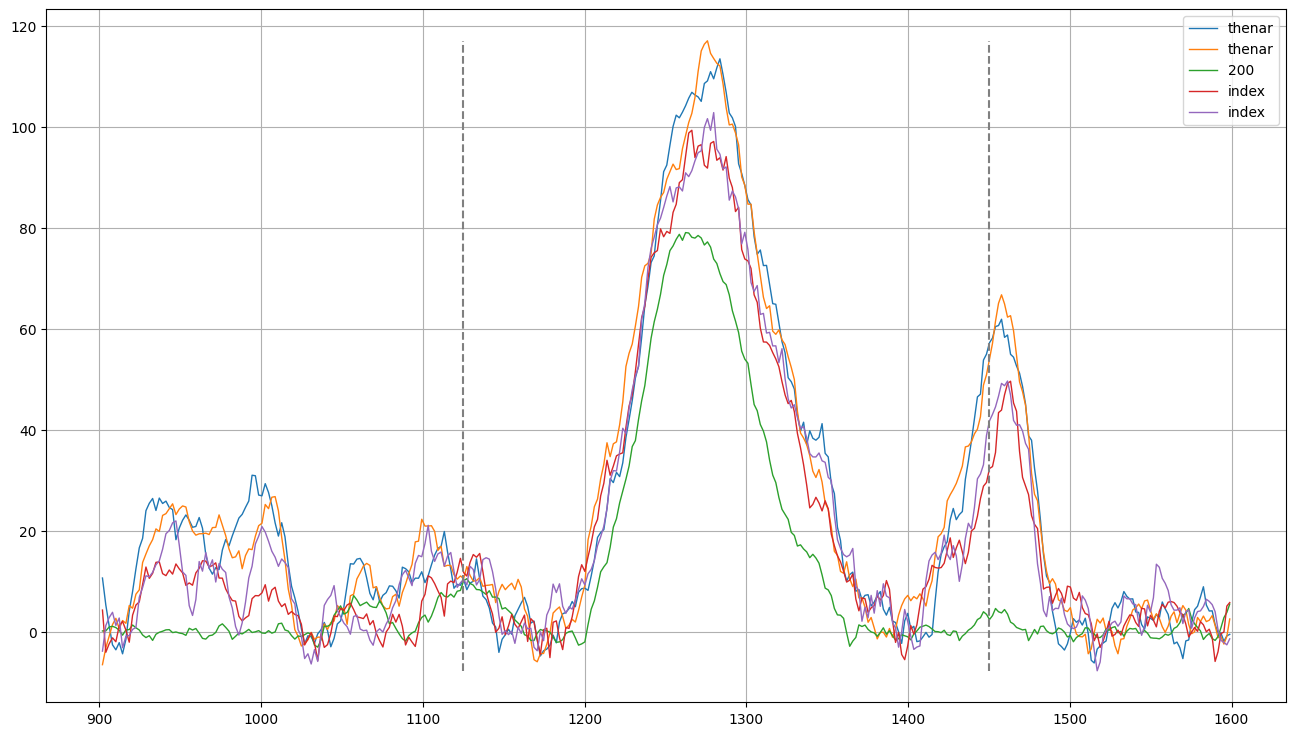

In [61]:
fig, ax = plt.subplots(figsize=(16,9))
ymin, ymax = np.inf, np.inf * -1
for name, spectrum in zip(names, spectrums):
    print(name)
    # if(name == '200')
    # if(name not in ['index']): continue
    x = spectrum[:,0]
    y = spectrum[:,1]
    ax.plot(x,y, label=f"{name}", linewidth='1')
    
    if(ymin > y.min()):
        ymin = y.min()
    if(ymax < y.max()):
        ymax = y.max()


ax.vlines(x=1125, ymin=ymin, ymax=ymax, linestyle="--", color='grey')
ax.vlines(x=1450, ymin=ymin, ymax=ymax, linestyle="--", color='grey')
ax.grid()
ax.legend()
plt.show()

## Fit LorentzianModel

In [62]:
from lmfit import Parameter, Minimizer
from lmfit.models import LorentzianModel, ConstantModel
from sklearn.metrics import auc

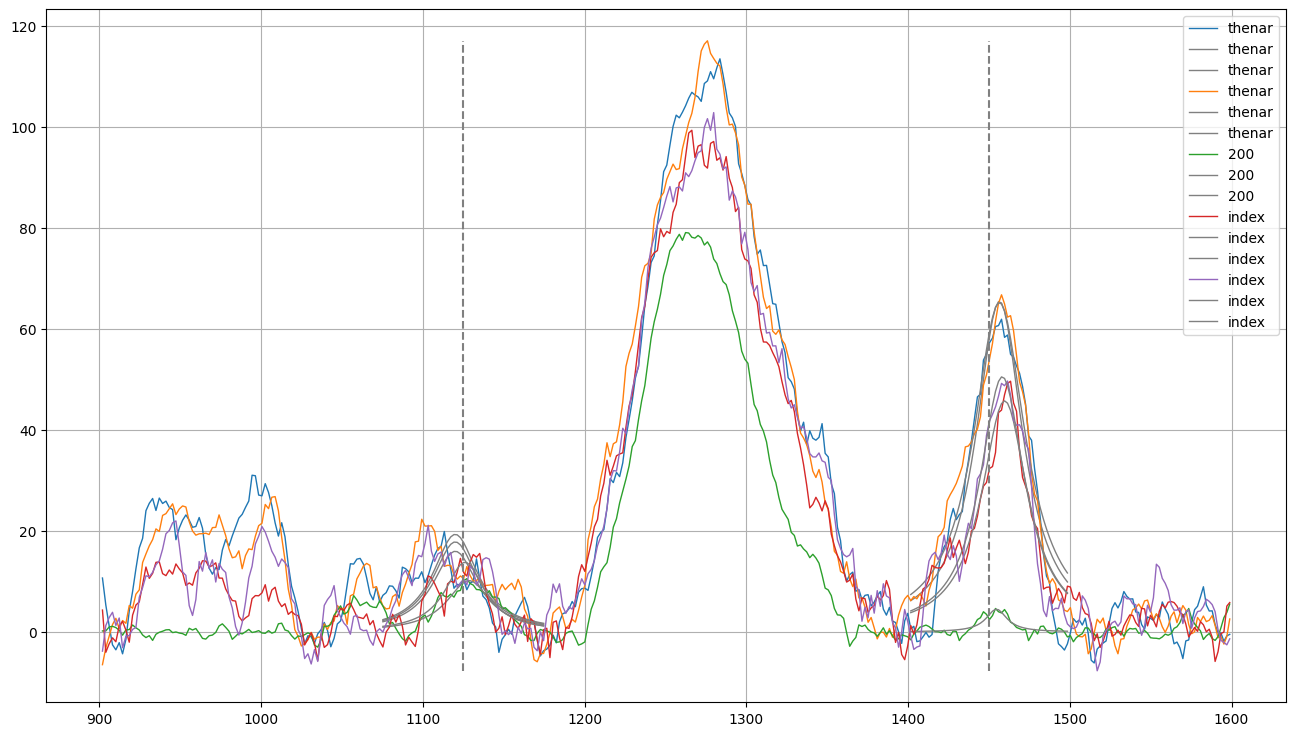

In [66]:
fig, ax = plt.subplots(figsize=(16,9))
ymin, ymax = np.inf, np.inf * -1
auc_1125s = []
auc_1450s = []
for name, spectrum in zip(names, spectrums):
    x = spectrum[:,0]
    y = spectrum[:,1]
    ax.plot(x,y, label=f"{name}", linewidth='1')
    
    model_1125 = LorentzianModel()
    params_1125 = model_1125.make_params()
    params_1125['center'].set(1125, min=1120, max=1130)
    params_1125['sigma'].set(16, min=15,max=17)
    result_1125 = model_1125.fit(y[range_1125], params_1125, x=x[range_1125])

    model_1450 = LorentzianModel()
    params_1450 = model_1450.make_params()
    params_1450['center'].set(1450)
    result_1450 = model_1450.fit(y[range_1450], params_1450, x=x[range_1450])

    auc_1125 = auc(x[range_1125], result_1125.best_fit)
    auc_1450 = auc(x[range_1450], result_1450.best_fit)

    ax.plot(x[range_1125],result_1125.best_fit, label=f"{name}", linewidth='1', c='grey')
    ax.plot(x[range_1450],result_1450.best_fit, label=f"{name}", linewidth='1', c='grey')

    auc_1125s.append(auc_1125)
    auc_1450s.append(auc_1450)
    if(ymin > y.min()):
        ymin = y.min()
    if(ymax < y.max()):
        ymax = y.max()


ax.vlines(x=1125, ymin=ymin, ymax=ymax, linestyle="--", color='grey')
ax.vlines(x=1450, ymin=ymin, ymax=ymax, linestyle="--", color='grey')
ax.grid()
ax.legend()
plt.show()

thenar 672.3148791995961 2818.9989344613628 0.23849419415550718
thenar 813.2795462587056 3020.6012858561753 0.26924425612438463
index 528.3813568250786 1942.512889341412 0.2720091896039982
index 750.1626632507091 2100.1668829645787 0.35719193047734643


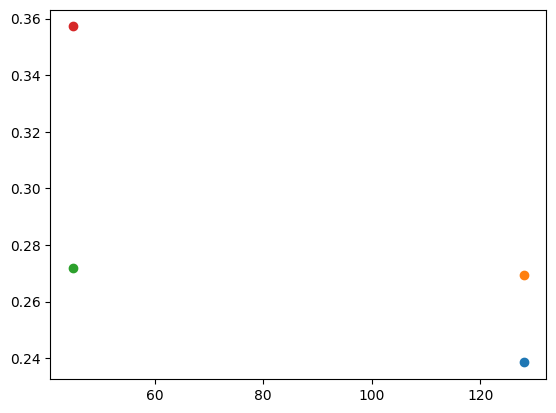

In [71]:
for name, auc_1125, auc_1450 in zip(names, auc_1125s, auc_1450s):
    if(name == '200'): continue
    print(name, auc_1125, auc_1450, auc_1125 / auc_1450)
    x = 45
    if(name == 'thenar'):
        x = 128
    plt.scatter(x, auc_1125 / auc_1450)
plt.show()

In [64]:
range_1125 = (x >= 1075) & (x <= 1175)
range_1450 = (x >= 1400) & (x <= 1500)

In [53]:
model_1125 = LorentzianModel()
params_1125 = model_1125.make_params()
params_1125['center'].set(1125, min=1120, max=1130)
params_1125['sigma'].set(16, min=15,max=17)
result_1125 = model_1125.fit(y[range_1125], params_1125, x=x[range_1125])



model_1450 = LorentzianModel()
params_1450 = model_1450.make_params()
params_1450['center'].set(1450)
result_1450 = model_1450.fit(y[range_1450], params_1450, x=x[range_1450])

In [54]:
result_1125

In [55]:
result_1450

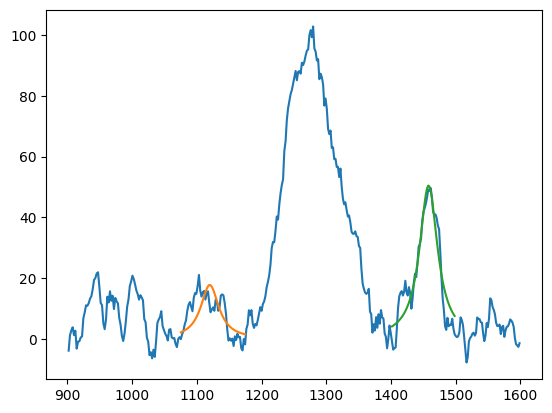

In [56]:
plt.plot(x,y)
plt.plot(x[range_1125],result_1125.best_fit)
plt.plot(x[range_1450],result_1450.best_fit)
plt.show()

In [60]:
auc(x[range_1125], result_1125.best_fit)
auc(x[range_1450], result_1450.best_fit)

2100.1668829645787

In [17]:
model=ConstantModel()
params=model.make_params()
params['c'].set(0,min=0,max=25)

l1=LorentzianModel(prefix='l1_')
l2=LorentzianModel(prefix='l2_')
l3=LorentzianModel(prefix='l3_')
l4=LorentzianModel(prefix='l4_')

p1=l1.make_params()
p1['l1_center'].set(1125, min=1000,max=1150)

p2=l2.make_params()
# p2['l2_center'].set(1450, min=1400,max=1500)

p3=l3.make_params()
p3['l3_center'].set(1100, min=1100,max=1150)

# p4=l4.make_params()
# p4['l4_center'].set(, min='1100',max='1150')

In [18]:
model = model + l1 + l2
params.update(p1)
params.update(p2)

name,value,initial value,min,max,vary,expression
c,0.00000000,0,0.00000000,25.0000000,True,
l1_amplitude,1.00000000,None,-inf,inf,True,
l1_center,1125.00000,1125,1000.00000,1150.00000,True,
l1_sigma,1.00000000,None,0.00000000,inf,True,
l1_fwhm,2.00000000,None,-inf,inf,False,2.0000000*l1_sigma
l1_height,0.31830990,None,-inf,inf,False,"0.3183099*l1_amplitude/max(1e-15, l1_sigma)"
l2_amplitude,1.00000000,None,-inf,inf,True,
l2_center,0.00000000,None,-inf,inf,True,
l2_sigma,1.00000000,None,0.00000000,inf,True,
l2_fwhm,2.00000000,None,-inf,inf,False,2.0000000*l2_sigma


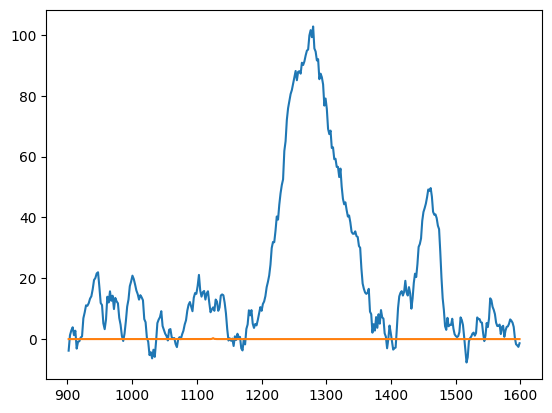

In [19]:
init=model.eval(params=params,x=x)
plt.plot(x,y)
plt.plot(x,init)

In [20]:
result=model.fit(data=y, params=params, x=x)
comps=result.eval_components()

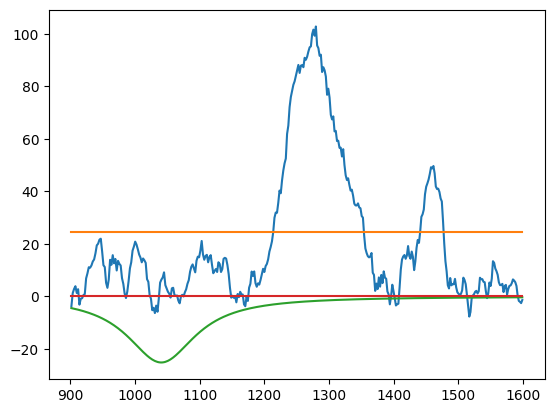

In [21]:
plt.plot(x,y)

for name,comp in comps.items():
    plt.plot(x, comp)

# plt.plot(x,result.best_fit)